## Robot Learning

## Assignment 6

#### Group names: Edit this cell and write your names here

### Introduction

Please carefully read the following description of the card game *Blackjack*.

The goal of Blackjack is to draw cards such that their values sum to as close to 21 as possible, but do not exceed 21. All cards 2 through 10 are assigned their number as the respective value, face cards like Jack, Queen and King yield a value of 10 points. The aces are special; they can count as either 1 or 11, depending on what is more beneficial. When using the ace as 11 points does not cause the total value of the hand to exceed 21, the ace is called 'usable'. 

The actions are to *stick*, which means to stop drawing cards and let the dealer play, or to *hit*, which means to draw another card to add to your hand. 

The opponent is a dealer with a fixed strategy; the dealer will always hit when the dealer's sum of card values is below 17 points. At or above 17 points, the dealer immediately sticks, irrespective of the player's card sum. Note that the dealer only starts playing once the player is finished, so when the player has selected to stick.

The game starts by drawing two cards each to player and dealer from an infinite deck. The player can see the own cards, but only the first card which the dealer recieves, the other is face-down. If the player hits and exceeds 21 points, the player is considered *bust* and immediately loses the game. When the player decides to stick, the dealer will draw cards according to its strategy. If the dealer goes *bust* in the process, the player immediately wins the game. If not, the sum of the dealer's card values is compared to the sum of the player's card values. If they are equal, the game is considered a draw. If the player has a higher score, the player wins, and vice versa.

In this RL setting, the rewards are +1 for winning, -1 for losing, and 0 for drawing and all intermediate moves. The state is a 3-tuple consisting of the players current hand sum, the value of the dealer's initial open card and a boolean describing whether the player currently has a usable ace or not. The action space consists of the integer $0$, which corresponds to *stick*, and the integer $1$, which corresponds to *hit*. Note that this corresponds exactly to the scenario described in [Example 5.1 in Reinforcement Learning: An Introduction by Sutton and Barto.](http://incompleteideas.net/book/the-book-2nd.html)

To get started, please examine the following code cell, which loads the Blackjack environment from the utils file and plays an episode. The player is in this case the random agent. The environment is equivalent to the one provided in OpenAI Gym; we adapted the source code so that installing this python package is not necessary.

In [6]:
import numpy as np
from utils import BlackjackEnv

# create a Blackjack environment
casino = BlackjackEnv()

# do this before each new episode
# state is 3-tuple: (player_current_sum, dealer_first_open_card, usable_ace_bool)
# if dealer_first_open_card == 1, the dealer is holding an ace!
starting_state = casino.reset()

# create flag tracking whether the episode is over
done = False

# create lists to save the trajectory and the decisions of the agent
actions, rewards, states = [], [], [starting_state]

# simulate until the episode is over
while not done:
    #in each non-terminal state the agent can either stick (0) or hit (1)
    possibleActions = casino.getAvailableActions()
    # select one of them randomly
    a = np.random.choice(possibleActions)
    # save the action
    actions.append(a)
    # execute the action using the step function
    # s is the new state
    # done is the flag whether the episode is over
    # the fourth output _ is a dict containing additional information on the environment
    # it is empty here, but passing it is according to convention in OpenAI Gym environments
    s, r, done, _ = casino.step(action = a)
    # save the states
    rewards.append(r)
    states.append(s)
    
print('Action Sequence:', actions)
print('Obtained Rewards:', rewards)
print('State Transitions:', states)

Action Sequence: [0]
Obtained Rewards: [-1.0]
State Transitions: [(11, 4, 0), (11, 4, 0)]


### Task 23

Implement Sarsa($\lambda$) for Blackjack. Use a time-varying scalar step-size of $\alpha_t = \frac{1}{N(s_t,a_t)}$ and an $\varepsilon$-greedy exploration strategy with annealing:

$$\varepsilon_t = \frac{N_0}{N_0 + N(s_t)}$$

where $N_0$ is a constant, $N(s)$ is the number of times state $s$ has been
visited, and $N(s, a)$ is the number of times action $a$ has been selected in state $s$. This procedure is robust over a large selection of different $N_0$, you can tune this value if you like, reasonable choices include, but are not limited to: $N_0=3$, $N_0=25$ or $N_0=90$.

Run the algorithm with parameter values $\lambda \in \{0, 0.1, 0.2, \dots, 1\}$. Stop exploration and learning
after $10000$ episodes and plot the average return for the next $10000$ episodes against $\lambda$. 

Note that there is a loop over all state-actions pairs in the Sarsa($\lambda$) algorithm. This loop is straightforward (but also necessary) to vectorize. Do not hesitate to contact your tutors if you need help with this step.

<div style="text-align: right; font-weight:bold"> 7 Points </div>

In [2]:
import matplotlib.pyplot as plt

In [3]:
def getEpsilonGreedyAction(Q,state,N,N_0):
    
    sa_0 = tuple(list(state) + [0])
    sa_1 = tuple(list(state) + [1])    
    epsilon = N_0 / (N_0 + N[state])
    
    if np.random.rand() > epsilon or Q[sa_0] == Q[sa_1]:
        return np.random.randint(2)
    else:
        if Q[sa_0]>Q[sa_1]:
            return 0
        else:
            return 1
            
    

In [19]:
# Your code can go here
Q = np.zeros((32,11,2,2))# Q[s,a] where s= (sum in hand, dealer front card, usable ace)
#max sum in hand = 31, min sum in hand > 0, max dealer front card = 10, min dealer front card > 0
#even though any state (0,_,_,) or (_,0,_) is non attainable we keep it for making code simpler
#We just waste some memory and time by doing so

#a = 0/1
stateActionVisits = np.zeros((32,11,2,2)) #N(s,a)
stateVisits = np.zeros((32,11,2)) #N(s)
noEpisodes = 10000
epochRewards = []
N0_list = [3,25,90]
Lambda_list = np.linspace(0,1,num=11)
gamma = 1


In [6]:
# create a Blackjack environment
casino = BlackjackEnv()
avg_N0_Lambda_rewards = {}

#Looping over N_0 and Lambda to find best hyperparameter values
for N_0 in N0_list:
    for Lambda in Lambda_list:

        Q = np.zeros((32,11,2,2))
        stateActionVisits = np.zeros((32,11,2,2)) #N(s,a)
        stateVisits = np.zeros((32,11,2)) #N(s)
        
        
        #Training
        for epoch in range(noEpisodes):
            #print(f'Epoch No ',epoch)
            
            starting_state = casino.reset() #Get start state

            # create flag tracking whether the episode is over
            done = False

            e = np.zeros((32,11,2,2)) #reset eligibility trace

            s = starting_state
            stateVisits[starting_state]+=1
            
            a = getEpsilonGreedyAction(Q,s,stateVisits,N_0)
            #print(a)

            sa = tuple(list(s) + [a]) #state_action_pair
            #print(sa)
            stateActionVisits[sa]+=1

            #Running an epoch
            while not done:
                s_prime, r, done, _ = casino.step(action = a)
                stateVisits[s_prime]+=1

                a_prime = getEpsilonGreedyAction(Q,s_prime,stateVisits,N_0)


                sa_prime = tuple(list(s_prime) + [a_prime])
                #print(sa_prime)
                stateActionVisits[sa_prime]+=1
                
                delta = r + gamma*Q[sa_prime] - Q[sa]
                e[sa]+=1

                e = e*gamma*Lambda
                Q+= (1/stateActionVisits[sa]) * delta * e #Q update

                s = s_prime
                a = a_prime
                sa = sa_prime
                
        #Testing
        avg_reward = 0
        for epoch in range(noEpisodes):
            #print(f'Epoch No ',epoch)
            
            episodeReward = 0
            starting_state = casino.reset() #Get start state
            s = starting_state

            # create flag tracking whether the episode is over
            done = False
            
            a = np.argmax(Q[s[0],s[1],s[2],:]) #Choosing action with best Q values
            #Running an epoch
            while not done:
                s_prime, r, done, _ = casino.step(action = a)
                
                episodeReward+=r
                
                a_prime = np.argmax(Q[s[0],s[1],s[2],:]) #Choosing action with best Q values
            
            avg_reward += (episodeReward - avg_reward) / (epoch+1)

        avg_N0_Lambda_rewards[(Lambda,N_0)] = avg_reward


avg_N0_Lambda_rewards

{(0.0, 3): -0.20700000000000024,
 (0.1, 3): -0.49800000000000066,
 (0.2, 3): -0.3849999999999997,
 (0.30000000000000004, 3): -0.34800000000000014,
 (0.4, 3): -0.37199999999999983,
 (0.5, 3): -0.41799999999999954,
 (0.6000000000000001, 3): -0.43100000000000027,
 (0.7000000000000001, 3): -0.3620000000000003,
 (0.8, 3): -0.42699999999999955,
 (0.9, 3): -0.35500000000000015,
 (1.0, 3): -0.4840000000000002,
 (0.0, 25): -0.19799999999999995,
 (0.1, 25): -0.40099999999999975,
 (0.2, 25): -0.4260000000000004,
 (0.30000000000000004, 25): -0.43099999999999955,
 (0.4, 25): -0.48699999999999977,
 (0.5, 25): -0.39600000000000046,
 (0.6000000000000001, 25): -0.402,
 (0.7000000000000001, 25): -0.43000000000000055,
 (0.8, 25): -0.4330000000000003,
 (0.9, 25): -0.42400000000000015,
 (1.0, 25): -0.39800000000000013,
 (0.0, 90): -0.19499999999999995,
 (0.1, 90): -0.374,
 (0.2, 90): -0.42299999999999993,
 (0.30000000000000004, 90): -0.41600000000000026,
 (0.4, 90): -0.41799999999999954,
 (0.5, 90): -0.428

In [7]:
import pandas as pd #use pandas to plot bar charts

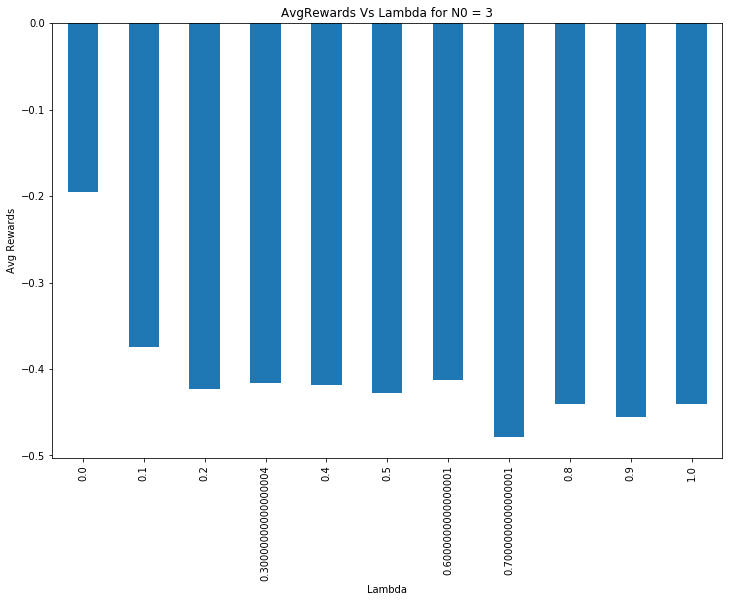

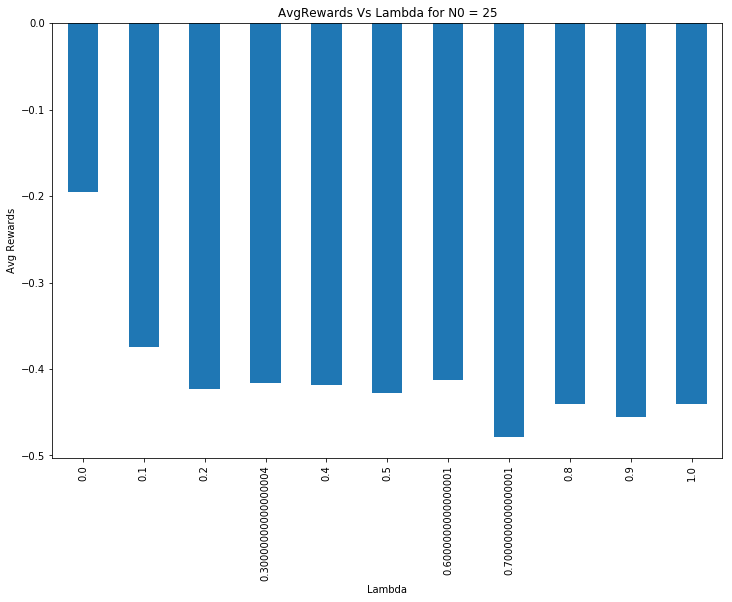

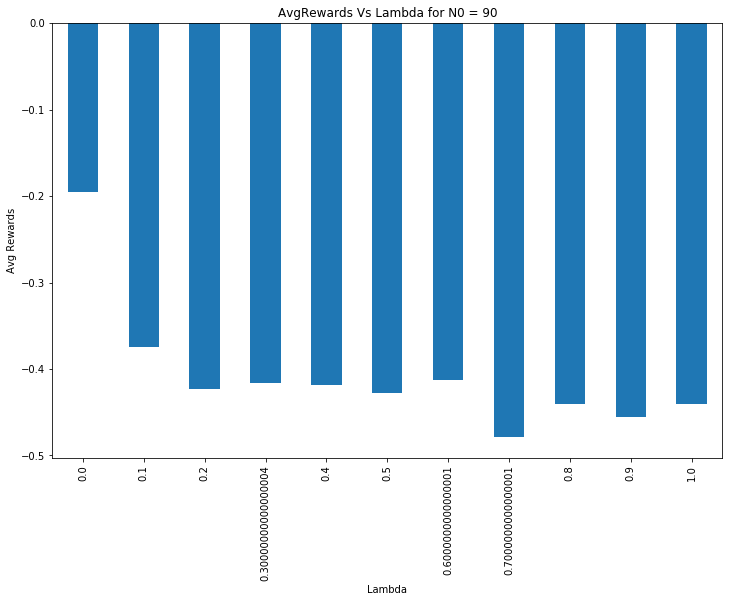

In [8]:
#Plotting for diff hyperparameters
for N0 in N0_list:
    avg_rewards = []
    for Lambda in Lambda_list:
        avg_rewards.append(avg_N0_Lambda_rewards[(Lambda,N_0)])
    
    #Code to plot beautiful bar charts
    freq_series = pd.Series(avg_rewards)
    plt.figure(figsize=(12, 8))
    ax = freq_series.plot(kind='bar')
    ax.set_title(f'AvgRewards Vs Lambda for N0 = {N0}')
    ax.set_xlabel('Lambda')
    ax.set_ylabel('Avg Rewards')
    ax.set_xticklabels(Lambda_list)
    plt.show()
    

We see that the result doesn't depend much on N0 but on lambda. Setting N0 = 25 and Lambda = 0, we get the best results.

### Task 24

Use your experiment from task 23 to select your favorite values for $\lambda$ and $N_0$. Once again, learn $Q$ using the Sarsa($\lambda$) algorithm for at least 10000 episodes (more is better). This time, show the progress of your training by plotting the average return over $1000$ episodes of greedy action selection according to the current $Q$-values every $1000$ training episodes. Finally, visualize the resulting policy, for example by seperately plotting the actions selected given a usable ace or no usable ace with respect to a given player sum and visible dealer card.

<div style="text-align: right; font-weight:bold"> 3 Points </div>

In [12]:
Q = np.zeros((32,11,2,2))
stateActionVisits = np.zeros((32,11,2,2)) #N(s,a)
stateVisits = np.zeros((32,11,2)) #N(s)
noEpisodes = 200000
epochRewards = []
N0 = 25
Lambda = 0.0
gamma = 1


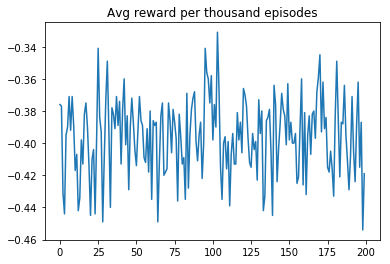

In [13]:
# create a Blackjack environment
casino = BlackjackEnv()

#Initialize Q , N(s) and N(s,a)
Q = np.zeros((32,11,2,2))
stateActionVisits = np.zeros((32,11,2,2)) #N(s,a)
stateVisits = np.zeros((32,11,2)) #N(s)

avg_per_thousand = []
total_reward_per_thousand = 0

#Training
for epoch in range(noEpisodes):
    #print(f'Epoch No ',epoch)
    
    starting_state = casino.reset() #Get start state

    # create flag tracking whether the episode is over
    done = False

    e = np.zeros((32,11,2,2)) #reset eligibility trace

    s = starting_state
    stateVisits[starting_state]+=1

    a = getEpsilonGreedyAction(Q,s,stateVisits,N_0)
    #print(a)

    sa = tuple(list(s) + [a]) #state_action_pair
    #print(sa)
    stateActionVisits[sa]+=1
    
    
    episodeReward = 0
    
    #Running an epoch
    while not done:
        s_prime, r, done, _ = casino.step(action = a)
        stateVisits[s_prime]+=1
        episodeReward+=r
        
        a_prime = getEpsilonGreedyAction(Q,s_prime,stateVisits,N_0)


        sa_prime = tuple(list(s_prime) + [a_prime])
        #print(sa_prime)
        stateActionVisits[sa_prime]+=1

        delta = r + gamma*Q[sa_prime] - Q[sa]
        e[sa]+=1

        e = e*gamma*Lambda
        Q+= (1/stateActionVisits[sa]) * delta * e #Q update

        s = s_prime
        a = a_prime
        sa = sa_prime
    
    total_reward_per_thousand+=episodeReward
    if (epoch+1) % 1000 == 0:
        avg_per_thousand.append(total_reward_per_thousand/(1000))
        total_reward_per_thousand = 0

        
plt.plot(range(len(avg_per_thousand)),avg_per_thousand)
plt.title("Avg reward per thousand episodes")
plt.show()

In [15]:
np.sum(Q==0)

1408

In [17]:
Q.shape

(32, 11, 2, 2)

In [18]:
32*11*4

1408

### Task 25

Now consider a simple coarse coding value function approximator that is based on a binary feature vector $\phi_{s, a} \in \mathbb{R}^{128}$ with $8 \times 4 \times 2 \times 2 = 128$ features. Each binary feature has a value of 1 iff $(s, a)$ lies within the cuboid of state-action-space corresponding to that feature. The cuboids have the following overlapping intervals:

$player(s) = \{[4, 7], [6, 9], [8, 11], [10, 13], [12, 15], [14, 17], [16, 19], [18, 21]\}$

$dealer(s) = \{[1, 4], [3, 6], [5, 8], [7, 10]\}$

$usable\_ace(s) = \{0,1\}$

$a = \{0, 1\}$

where

* player(s) is the sum of the player’s cards (4–21) in state s
* dealer(s) is the value of the dealer’s first card (1–10) in state s

Using this encoding, take one (legal) state-action pair (s,a) of your choosing and state $\sum_{i=1}^{128} \phi_{s, a}(i)$.

<div style="text-align: right; font-weight:bold"> 1 Point </div>

Please write your answer here.

Let s,a = (5,8,0,0)

This then belongs in two cuboids, one corresponding to [4,7] * [5,8] * 0 * 0 and the other corresponding to [4,7] * [7,10] * 0 * 0

So the sum is 2

### Task 26

Implement a function $phi(s,a)$ which takes a state-action pair $(s,a)$ and maps it to a vector $\phi_{s,a}$ as described above. Sanity-check this function by applying it to your example (s,a) from the previous task and then calculating the sum over all vector entries.

<div style="text-align: right; font-weight:bold"> 4 Points </div>

In [11]:
# Your code can go here
playerIntervals = [[4, 7], [6, 9], [8, 11], [10, 13], [12, 15], [14, 17], [16, 19], [18, 21]]
dealerIntervals = [[1, 4], [3, 6], [5, 8], [7, 10]]

def phi(s,a):
    representation = np.zeros(shape = (len(playerIntervals),len(dealerIntervals),2,2))
    
    for i,pInterval in enumerate(playerIntervals):
        if (s[0]>= pInterval[0]) and (s[0]<=pInterval[1]):
            
            for j,dInterval in enumerate(dealerIntervals):
                if (s[1]>= dInterval[0]) and (s[1]<=dInterval[1]):
                    
                    representation[i,j,s[2],a] = 1
                    
    return representation
                         
                
   

In [12]:
v = phi((5,8,0),0)
np.sum(v)

2.0

### Task 27

Repeat the Sarsa($\lambda$) experiment from task 23, but this time use a linear value function approximation $Q(s,a) = \theta \cdot \phi_{s,a}$. Use a constant exploration of $\varepsilon=0.05$ and a constant step-size of $\alpha=0.02$. 

As previously, run the algorithm with parameter values $\lambda \in \{0, 0.1, 0.2, \dots, 1\}$. Stop exploration and learning after $10000$ episodes and plot the average return for the next $10000$ episodes against $\lambda$. 

To clarify, $\theta$ is a row vector which your algorithm learns instead of $Q(s,a)$. The row vector times column vector product $Q(s,a) = \theta \cdot \phi_{s,a}$ can also be understood as $Q(s,a) = \sum_{i=0}^{127} \theta(i)\phi_{s,a}(i)$.

<div style="text-align: right; font-weight:bold"> 5 Points </div>